## Классические алгоритмы без ансамблирования
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.75$ - 0 баллов
- $0.75 < AUC \leq 0.76$ - 2 балла
- $0.76 < AUC \leq 0.77$ - 4 балла
- $0.77 < AUC \leq 0.78$ - 6 баллов
- $0.78 < AUC \leq 0.79$ - 8 баллов
- $AUC > 0.79$ - 10 баллов

\
В этой работе запрещено использовать ансамбли моделей (лес, бустинги и т.д.)!

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузка данных
data = pd.read_csv('german.csv', sep=';')
print('Размер датасета:', data.shape)
print(data.head())

# Разделение на X и y (целевая переменная в первом столбце)
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

# Стратифицированное разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f'Размер трейна: {X_train.shape}, теста: {X_test.shape}')

   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                             3               

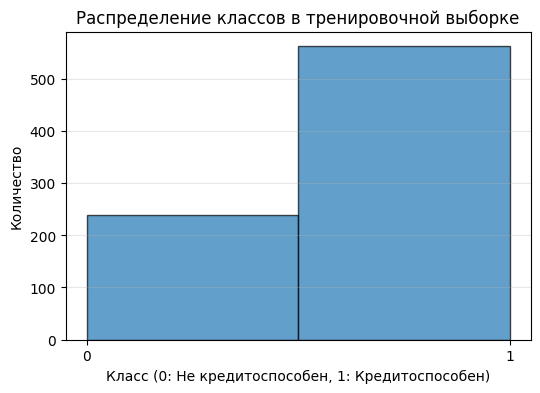

Начало поиска оптимальных гиперпараметров...
Обучение Logistic Regression...
Обучение Decision Tree...
Обучение Decision Tree...
Обучение KNN...

Лучшие параметры:
Logistic Regression (CV AUC: 0.7809)
  {'clf__C': 0.01, 'clf__penalty': 'l2'}
Decision Tree (CV AUC: 0.7309)
  {'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}
KNN (CV AUC: 0.7448)
  {'clf__metric': 'euclidean', 'clf__n_neighbors': 9, 'clf__weights': 'distance'}
Обучение KNN...

Лучшие параметры:
Logistic Regression (CV AUC: 0.7809)
  {'clf__C': 0.01, 'clf__penalty': 'l2'}
Decision Tree (CV AUC: 0.7309)
  {'clf__max_depth': 5, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}
KNN (CV AUC: 0.7448)
  {'clf__metric': 'euclidean', 'clf__n_neighbors': 9, 'clf__weights': 'distance'}


In [7]:
# Визуализация распределения классов
plt.figure(figsize=(6, 4))
plt.hist(y_train, bins=2, edgecolor='k', alpha=0.7)
plt.xticks([0, 1])
plt.xlabel('Класс (0: Не кредитоспособен, 1: Кредитоспособен)')
plt.ylabel('Количество')
plt.title('Распределение классов в тренировочной выборке')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Создание пайплайнов для каждой модели
pipe_log = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42))
])

pipe_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=42))
])

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

# Определение сеток гиперпараметров для поиска
param_grid_log = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l2']
}

param_grid_dt = {
    'clf__max_depth': [3, 5, 7, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

param_grid_knn = {
    'clf__n_neighbors': [3, 5, 7, 9, 11],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan']
}

# Стратифицированная кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV с оценкой по ROC-AUC (критерий оценки)
print('Начало поиска оптимальных гиперпараметров...')

gs_log = GridSearchCV(pipe_log, param_grid_log, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0)
gs_dt = GridSearchCV(pipe_dt, param_grid_dt, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0)
gs_knn = GridSearchCV(pipe_knn, param_grid_knn, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0)

print('Обучение Logistic Regression...')
gs_log.fit(X_train, y_train)

print('Обучение Decision Tree...')
gs_dt.fit(X_train, y_train)

print('Обучение KNN...')
gs_knn.fit(X_train, y_train)

# Сохранение лучших моделей
logistic_regression_model = gs_log.best_estimator_
decision_tree_model = gs_dt.best_estimator_
knn_model = gs_knn.best_estimator_

# Вывод лучших параметров
print('\n' + '='*60)
print('Лучшие параметры:')
print('='*60)
print(f'Logistic Regression (CV AUC: {gs_log.best_score_:.4f})')
print(f'  {gs_log.best_params_}')
print(f'Decision Tree (CV AUC: {gs_dt.best_score_:.4f})')
print(f'  {gs_dt.best_params_}')
print(f'KNN (CV AUC: {gs_knn.best_score_:.4f})')
print(f'  {gs_knn.best_params_}')

In [8]:
# Оценка моделей на тестовой выборке
models = {
    'Logistic Regression': logistic_regression_model,
    'Decision Tree': decision_tree_model,
    'KNN': knn_model
}

results = {}

# Вычисление метрик для каждой модели
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall
    }

# Вывод результатов в табличной форме
print('\n' + '='*80)
print('РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:')
print('='*80)
print(f"{'Модель':<25} {'Accuracy':<12} {'ROC-AUC':<12} {'Precision':<12} {'Recall':<12}")
print('-'*80)

for name, vals in results.items():
    print(f"{name:<25} {vals['accuracy']:<12.4f} {vals['roc_auc']:<12.4f} {vals['precision']:<12.4f} {vals['recall']:<12.4f}")

print('='*80)


РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:
Модель                    Accuracy     ROC-AUC      Precision    Recall      
--------------------------------------------------------------------------------
Logistic Regression       0.7150       0.7922       0.7314       0.9275      
Decision Tree             0.7000       0.7062       0.7378       0.8768      
KNN                       0.7600       0.7739       0.7778       0.9130      


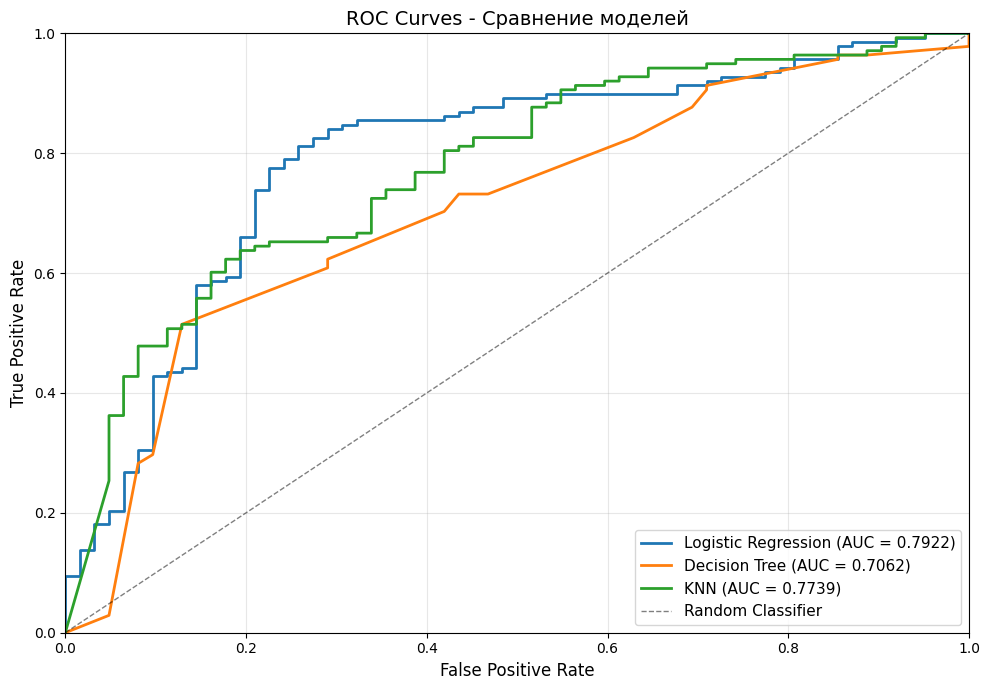

In [9]:
# Построение ROC-кривых для сравнения моделей
plt.figure(figsize=(10, 7))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.4f})')

# Диагональная линия (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Random Classifier')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Сравнение моделей', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
# Анализ результатов и оценка по критериям задачи
print('\n' + '='*80)
print('ОЦЕНКА ПО КРИТЕРИЯМ ЗАДАЧИ (ROC-AUC на тестовых данных):')
print('='*80)

scoring_criteria = [
    (0.75, 0, "AUC ≤ 0.75"),
    (0.76, 2, "0.75 < AUC ≤ 0.76"),
    (0.77, 4, "0.76 < AUC ≤ 0.77"),
    (0.78, 6, "0.77 < AUC ≤ 0.78"),
    (0.79, 8, "0.78 < AUC ≤ 0.79"),
    (float('inf'), 10, "AUC > 0.79")
]

for name, vals in results.items():
    auc = vals['roc_auc']
    for threshold, score, criterion in scoring_criteria:
        if auc <= threshold:
            print(f"{name:<25} | AUC = {auc:.4f} | {criterion:<18} | Баллы: {score}")
            break

print('='*80)


ОЦЕНКА ПО КРИТЕРИЯМ ЗАДАЧИ (ROC-AUC на тестовых данных):
Logistic Regression       | AUC = 0.7922 | AUC > 0.79         | Баллы: 10
Decision Tree             | AUC = 0.7062 | AUC ≤ 0.75         | Баллы: 0
KNN                       | AUC = 0.7739 | 0.77 < AUC ≤ 0.78  | Баллы: 6


## Экспериментируйте

Для получения лучшего качества (более высокий ROC-AUC):
- Измените сетки гиперпараметров (добавьте/удалите значения)
- Попробуйте исключить или включить признаки
- Экспериментируйте с методами нормализации и масштабирования
- Измените функцию потерь или метод оптимизации
- Используйте разные методы разделения на выборки (разные random_state)

**Помните:** В этой работе запрещено использовать ансамбли (RandomForest, GradientBoosting и т.д.)!